# Bicicleta de Whipple


Modelo linearizado em torno de uma solução em regime permanente na qual a bicicleta descreve uma translação em linha reta com velocidade \(v\) constante [(Meijaard *et al.*, 2007)](https://dx.doi.org/10.1098/rspa.2007.1857):
\begin{align*}
    M \ddot q = - v C_1 \dot q - (g K_0 + v^2 K_2 ) q + \tau
\end{align*}
com $q = (\phi, \delta) \in \mathbb{R}^2$ e $\tau = (\tau_\phi, \tau_\delta) = (w, u)$.

In [4]:
# !pip install sympy
# !pip install control
# !pip install tbcontrol
# !pip install ipywidgets

In [5]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import control as ct
from tbcontrol.symbolic import routh

# import ipywidgets as widgets
# from ipywidgets import interactive

In [6]:
# Paleta de cores
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

## 1. Sistema na forma de espaço de estados

\begin{align*}
    & \dot x = A(v) x + B u + E w \\ 
    & y = C x
\end{align*}

In [7]:
v = sp.symbols('v')

M = sp.Matrix([[80.81722, 2.31941332208709],
              [2.31941332208709, 0.29784188199686]])

K0 = sp.Matrix([[-80.95,-2.59951685249872],
                [-2.59951685249872,-0.80329488458618]])

K2 = sp.Matrix([[0,76.59734589573222],
                [0,2.65431523794604]])

C1 = sp.Matrix([[0,33.86641391492494],
                [-0.85035641456978,1.68540397397560]])

A = sp.Matrix([[sp.zeros(2,2), sp.eye(2)],
               [- M.inv() * (9.81 * K0 + v * v *K2), -M.inv()*(v*C1)]])

Be = sp.Matrix([[sp.zeros(2,2)],
               [M.inv()]])

B = Be[:, 1]
E = Be[:, 0]

C_φ = sp.Matrix([[1, 0, 0, 0]])
C_δ = sp.Matrix([[0, 1, 0, 0]])

An = sp.lambdify((v), A)
Bn = np.array(B)
En = np.array(E)

## 2. Função de transferência em malha aberta

In [57]:
bike_ss = ct.ss(An(6), B, C_φ, 0)

In [58]:
G_p0 = ct.tf(bike_ss)
G_p0

TransferFunction(array([-1.24092025e-01, -1.08714178e+01, -1.46166191e+02]), array([  1.        ,  19.14232786,  86.05069461, 593.3528833 ,
         2.41168533]))

In [9]:
G_p0.num[0][0]

array([-1.24092025e-01, -1.08714178e+01, -1.46166191e+02])

In [10]:
G_p0.den[0][0]

array([  1.        ,  19.14232786,  86.05069461, 593.3528833 ,
         2.41168533])

In [55]:
# elimina, se aparecer, um termo efetivamente nulo (< 1e-10 * s^3) no numerador
if (np.abs(G_p0.num[0][0][0]) < 1e-10):
    G_p = ct.tf(G_p0.num[0][0][1:], G_p0.den[0][0])
else:
    G_p = G_p0

In [56]:
G_p

TransferFunction(array([-1.24092025e-01, -1.08714178e+01, -1.46166191e+02]), array([  1.        ,  19.14232786,  86.05069461, 593.3528833 ,
         2.41168533]))

In [31]:
G_p.poles()

array([-1.60853712e+01+0.j        , -1.52644487e+00+5.87673061j,
       -1.52644487e+00-5.87673061j, -4.06690077e-03+0.j        ])

In [32]:
G_p.zeros()

array([-71.02318781+0.j, -16.58451952+0.j])

## 3. Ganho crítico de controle via Routh-Hurwitz

In [33]:
K_c = sp.symbols('K_c')
s = sp.symbols('s')
p_CL = K_c * sp.Poly(G_p.num[0][0], s) + sp.Poly(G_p.den[0][0], s)
rh_CL = routh(p_CL)
rh_CL

Matrix([
[                                                                                                                                                               1.0, 86.0506946134026 - 0.124092025411581*K_c, 2.41168533404044 - 146.166190513899*K_c],
[                                                                                                                                                  19.1423278634325,  593.352883302431 - 10.8714178437542*K_c,                                       0],
[                                                                                                                           0.443833564480849*K_c + 55.053791439682,  2.41168533404044 - 146.166190513899*K_c,                                       0],
[                                                    (-4.82510013255414*K_c**2 + 2462.79829593342*K_c + 32620.1606160984)/(0.443833564480849*K_c + 55.053791439682),                                        0,                                      

In [34]:
sp.solve(rh_CL[2, 0] > 0, K_c)

(-124.0415233221 < K_c) & (K_c < oo)

In [35]:
sp.solve(rh_CL[3, 0] > 0, K_c)

((-12.9182106220819 < K_c) & (K_c < 523.33213536477)) | ((-oo < K_c) & (K_c < -124.0415233221))

In [36]:
sp.solve(rh_CL[4, 0] > 0, K_c)

((-12.9182106220819 < K_c) & (K_c < 0.0164996113366662)) | ((-oo < K_c) & (K_c < -12.9182106220819))

In [37]:
# ganho crítico (ultimate gain)
K_u = -12.9182106220824
T_u = ct.feedback(K_u * G_p)
routh(sp.Poly(T_u.den[0][0], s))

Matrix([
[                  1.0, 87.6537415341902, 1890.61732022001],
[     19.1423278634325, 733.792148768713,                0],
[     49.3202559725688, 1890.61732022001,                0],
[-2.83247488151764e-11,                0,                0],
[     1890.61732022001,                0,                0]])

In [38]:
cl_poles_u = T_u.poles()
cl_poles_u

array([-1.60740035e+01+0.j        ,  5.39568390e-14+6.19140417j,
        5.39568390e-14-6.19140417j, -3.06832432e+00+0.j        ])

In [39]:
# período com ganho crítico
P_u = 2*np.pi/np.imag(cl_poles_u[1])
P_u

1.0148239619803572

## 4. Sintonia de PID via Ziegler-Nichols

| Control | $K_c$         | $\tau_I$          | $\tau_D$        |
| :-----: | :-----------: | :---------------: | :-------------: |
| P       | $0.5 K_{u}$  | -                 | -               |
| PI      | $0.45 K_{u}$ | $\frac{P_u}{1.2}$ | -               |
| PID     | $0.6 K_{u}$  | $\frac{P_u}{2}$   | $\frac{P_u}{8}$ |

In [40]:
K_c_zn = 0.6 * K_u
τ_i = P_u/2
τ_d = P_u/8

N_d = 10000
G_c_zn = K_c_zn * (1 + ct.tf([1], [τ_i, 0]) + ct.tf([τ_d, 0], [τ_d/N_d, 1]))
G_c_zn

TransferFunction(array([-0.49895167, -3.93301123, -7.75092637]), array([6.43667296e-06, 5.07411981e-01, 0.00000000e+00]))

In [41]:
# FT em malha fechada
T_zn = ct.feedback(G_c_zn * G_p)
T_zn

TransferFunction(array([6.19159236e-02, 5.91236744e+00, 1.16649102e+02, 6.59136828e+02,
       1.13292338e+03]), array([6.43667296e-06, 5.07535194e-01, 9.77551631e+00, 4.95793401e+01,
       4.17723479e+02, 6.60360546e+02, 1.13292338e+03]))

In [42]:
T_zn.poles()

array([-7.88312843e+04+0.j        , -1.60929885e+01+0.j        ,
       -7.62899583e-01+6.33780788j, -7.62899583e-01-6.33780788j,
       -8.22722579e-01+1.65161172j, -8.22722579e-01-1.65161172j])

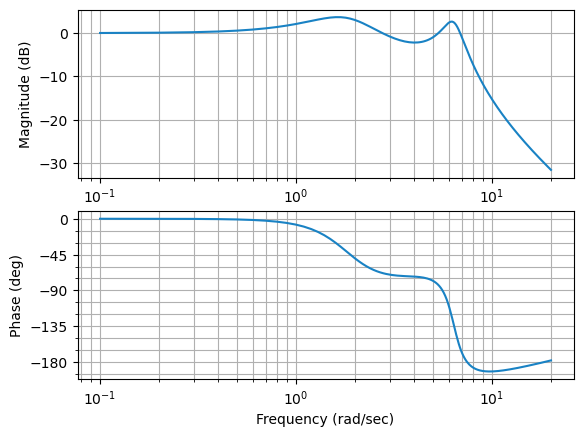

In [43]:
# diagrama de Bode em MF
M_zn, φ_zn, ω_zn = ct.bode_plot(T_zn, 
                                omega=np.linspace(0.1, 20, 201), 
                                color=cp['blue'], 
                                dB=True)

In [44]:
# FT entre referência e entrada de controle (torque τ_δ)
T_rτ_δ_zn = ct.feedback(G_c_zn, G_p)
T_rτ_δ_zn

TransferFunction(array([-4.98951672e-01, -1.34841077e+01, -1.25973055e+02, -7.82863535e+02,
       -3.00183947e+03, -4.60851970e+03, -1.86927955e+01]), array([6.43667296e-06, 5.07535194e-01, 9.77551631e+00, 4.95793401e+01,
       4.17723479e+02, 6.60360546e+02, 1.13292338e+03]))

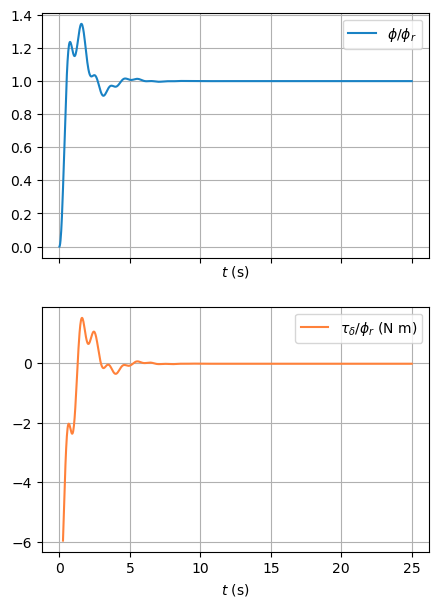

In [45]:
# simulação do sistema em MF
ts = np.linspace(0, 25, 1000)

t, y = ct.step_response(T_zn, ts)
t, u = ct.step_response(T_rτ_δ_zn, ts)

fig, (state, control_input) = plt.subplots(
        2, 1, figsize=(5, 7), sharex=True)

state.plot(t, y,
            color=cp['blue'], label=r'$\phi / \phi_r$ ')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

control_input.plot(t[10:], u[10:], color=cp['orange'],
                    label=r'$\tau_\delta/\phi_r$ (N m)')
# control_input.set_ylabel(r'(N m)')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()